# Collaborative Filtering
This notebook aims to build a recommender system using User-Based K-nearest Neighbours (KNN) with Means.

*Prepared by: Chan Cheah Cha, Chua Kai Bing, Goh Jia Yi, Lim Jia Qi, Tan Zen Wei*

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

In [ ]:
# Setting paths
root = '/content/drive/MyDrive/BT4014/Codes/Data/'

In [ ]:
beer_df = pd.read_csv(root + 'beer_reviews.csv')
beer_df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [ ]:
# Highest Review Count
beer_df['count'] = 1
beer_count = beer_df[['beer_name','count']].groupby('beer_name').sum().sort_values(by=['count'],ascending=False)
beer_count = beer_count.reset_index()
mostpop10 = list(beer_count['beer_name'][:10])

# Find out which beers have the highest review score
beer_reviews = beer_df[['beer_name','review_overall']].groupby('beer_name').mean().sort_values(by=['review_overall'],ascending=False)
beer_reviews = beer_reviews.reset_index()
beer_reviews.rename(columns={'review_overall': 'review_mean'}, inplace=True)  ##rename aggregated col

# join both df
#review_overall here is mean review score
beer_combined = pd.merge(beer_count, beer_reviews, on=["beer_name"])

# Keep only Top 100 >= 4.0 review score and > 100 reviews
filtered = beer_combined[(beer_combined["count"] >=100) &(beer_combined["review_mean"]>= 4.0)].sort_values("review_mean",ascending=False)

#Only keep 100 beer that are not in the most popular 10 by review count
boolean_series = ~filtered['beer_name'].isin(mostpop10)
reco_df = filtered[boolean_series][:100].reset_index(drop=True)

#list of 100 beers to recommend
recobeers = list(reco_df['beer_name'])
#Keep only reviews that mentioned the 100 beers we plan to recommend
reco_reviews = beer_df[beer_df['beer_name'].isin(recobeers)]
#Clean up reviews with NaN
reco_reviews = reco_reviews[reco_reviews['review_profilename'].notnull()].sort_values(by="review_profilename")
reco_reviews

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,count
800247,18149,The Lost Abbey,1224438466,4.0,5.0,3.5,0110x011,American Wild Ale,4.5,5.0,Isabelle Proximus,7.00,42816,1
661342,3120,Alpine Beer Company,1243095767,4.5,4.5,5.0,0110x011,American Double / Imperial IPA,5.0,5.0,Exponential Hoppiness,11.00,12068,1
579247,2210,Firestone Walker Brewing Co.,1232206678,5.0,5.0,5.0,0110x011,American Strong Ale,5.0,5.0,Firestone 11 - Anniversary Ale,11.00,39873,1
33700,1199,Founders Brewing Company,1223914717,5.0,4.5,4.5,0110x011,American Double / Imperial Stout,5.0,5.0,Founders KBS (Kentucky Breakfast Stout),11.20,19960,1
614981,199,Ballast Point Brewing Company,1240193211,4.5,4.0,3.5,0110x011,American IPA,4.0,4.0,Sculpin India Pale Ale,7.00,29619,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155929,396,AleSmith Brewing Company,1166221983,4.5,5.0,4.0,zuggy9,American IPA,4.5,5.0,AleSmith IPA,7.25,3916,1
779267,13014,Surly Brewing Company,1293689525,4.0,4.0,4.5,zulufactor,American Double / Imperial IPA,4.0,5.0,Abrasive Ale,9.00,46849,1
422480,73,Great Lakes Brewing Company,1294898238,3.5,4.5,4.5,zulufactor,American Porter,4.0,4.5,Great Lakes Edmund Fitzgerald Porter,5.80,226,1
1491252,313,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,1278358162,4.5,5.0,4.5,zwalk8,Quadrupel (Quad),5.0,5.0,Trappist Westvleteren 12,10.20,1545,1


In [ ]:
## users that only have 1 review
reco_reviews[reco_reviews.groupby('review_profilename').review_profilename.transform(len) == 1]

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,count
662010,3120,Alpine Beer Company,1323364958,5.0,5.0,4.5,01Ryan10,American IPA,5.0,5.0,Duet IPA,7.0,27604,1
688950,252,Bayerische Staatsbrauerei Weihenstephan,1275104227,4.5,5.0,4.5,0beerguy0,Dunkelweizen,4.5,4.0,Weihenstephaner Hefeweissbier Dunkel,5.3,808,1
660748,3120,Alpine Beer Company,1238301804,4.0,4.0,4.5,1000Bottles,American Double / Imperial IPA,3.5,4.0,Pure Hoppiness,8.0,7597,1
373315,22,Unibroue,1273194401,5.0,4.0,4.0,1100.0,Tripel,4.5,5.0,La Fin Du Monde,9.0,34,1
1295344,18006,Half Acre Beer Company,1259551754,4.5,4.0,4.5,110toyourleft,American Pale Ale (APA),4.0,4.5,Daisy Cutter Pale Ale,5.2,48582,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20544,1199,Founders Brewing Company,1293511483,5.0,4.5,4.5,ztaylor1,American Double / Imperial Stout,5.0,5.0,Founders Breakfast Stout,8.3,11757,1
372894,22,Unibroue,1300931609,4.0,4.5,4.0,ztoellner,Tripel,4.5,4.0,La Fin Du Monde,9.0,34,1
969791,222,Brouwerij Duvel Moortgat NV,1180631506,5.0,4.5,5.0,ztprez,Belgian Strong Pale Ale,5.0,5.0,Duvel,8.5,695,1
1491252,313,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,1278358162,4.5,5.0,4.5,zwalk8,Quadrupel (Quad),5.0,5.0,Trappist Westvleteren 12,10.2,1545,1


## User Based CF with Surprise

In [ ]:
#Surprise is a Python SciKit that comes with various recommender algorithms and similarity metrics to make it easy to build and analyze recommenders.
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 11.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617601 sha256=9effd3cdb2daff451b266e5f7c46b4093ce8844bc2d39cbf7df2f02212a7053d
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from __future__ import (absolute_import, division, print_function,             
                        unicode_literals)                                      
import pickle
import os

import pandas as pd

from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise import Dataset                                                     
from surprise import Reader                                                      
from surprise.model_selection.split import train_test_split
from surprise.accuracy import rmse,fcp,mae,mse

In [ ]:
# The columns must correspond to user id, item id and ratings (in that order).
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reco_reviews[['review_profilename', 'beer_name', 'review_overall']], reader)
trainset, testset = train_test_split(data, test_size=0.3,random_state=4014)

In [ ]:
print('Number of users in train set: ', trainset.n_users)
print('Number of items in train set: ', trainset.n_items)

Number of users in train set:  8989
Number of items in train set:  100


In [ ]:
#Do Grid Search to find the best parameters
param_grid = {'k': [30,40,50],
              'sim_options': {'name': ['cosine','msd','pearson'],
                              'user_based':['True','False']
                              }
              }

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

In [ ]:
## THE SELECTED MODEL##
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.5099803195306497
{'k': 50, 'sim_options': {'name': 'msd', 'user_based': 'True'}}


In [ ]:
#use best params from gridsearch = {'k': 50, 'sim_options': {'name': 'msd', 'user_based': 'True'}}
sim_options = {'name': 'msd','user_based': True}
algo = KNNWithMeans(k=50,sim_options=sim_options)
predictions = algo.fit(trainset).test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['user', 'beer', 'actual', 'predict', 'details'])
df['User Data in Train'] = df.user.apply(get_Iu)
df['Item Data in Train'] = df.beer.apply(get_Ui)
df['error'] = abs(df.actual - df.predict) #calculate error


In [ ]:
df.head()

,user,beer,actual,predict,details,User Data in Train,Item Data in Train,error
0,jackorain,AleSmith IPA,4.5,4.342058,"{'actual_k': 50, 'was_impossible': False}",11,682,0.157942
1,artusory,Trappistes Rochefort 10,4.0,4.134597,"{'actual_k': 50, 'was_impossible': False}",4,1514,0.134597
2,dsigmon,Supplication,4.5,4.330673,"{'actual_k': 50, 'was_impossible': False}",2,720,0.169327
3,depechemode1983,Founders Breakfast Stout,4.0,4.143257,"{'actual_k': 50, 'was_impossible': False}",4,1733,0.143257
4,eat,Weihenstephaner Hefeweissbier,5.0,4.424467,"{'actual_k': 50, 'was_impossible': False}",6,1328,0.575533


In [ ]:
print('Number of items in test set: ', len(df['beer'].unique()))
print('Number of users in test set: ', len(df['user'].unique()))

Number of items in test set:  100
Number of users in test set:  6121


In [ ]:
#dont have sufficient user information, therefore unable to determine. Maybe user only made 1 review or no data assigned to train set 
len(df[df['User Data in Train']==0]['user'].unique())

1448

In [ ]:
#users without user data in train
solo = df[df['User Data in Train']==0][['user', 'beer', 'actual', 'predict','User Data in Train','error']]
solo

,user,beer,actual,predict,User Data in Train,error
7,duke1258,Founders Breakfast Stout,5.0,4.379839,0,0.620161
21,sleestak4life,Saison - Brett,4.5,4.379839,0,0.120161
39,Sleestak,Weihenstephaner Hefeweissbier Dunkel,5.0,4.379839,0,0.620161
42,littleg,Tröegs Nugget Nectar,5.0,4.379839,0,0.620161
46,ztprez,Duvel,5.0,4.379839,0,0.620161
...,...,...,...,...,...,...
18666,FlyFisher2782,Temptation,4.5,4.379839,0,0.120161
18669,JayRey,Tröegs Nugget Nectar,5.0,4.379839,0,0.620161
18671,ChuggyMcBeer,Daisy Cutter Pale Ale,5.0,4.379839,0,0.620161
18675,beejayud,Bell's Hopslam Ale,4.5,4.379839,0,0.120161


In [ ]:
#exclude users that are not in train set (lack of user information) 
pred = df[df['details']!= {'reason': 'User and/or item is unknown.', 'was_impossible': True}]
pred.sort_values(by='user')[:20]

,user,beer,actual,predict,details,User Data in Train,Item Data in Train,error
3842,0110x011,Firestone 11 - Anniversary Ale,5.0,4.500286,"{'actual_k': 50, 'was_impossible': False}",16,116,0.499714
10822,0110x011,Supplication,4.0,4.527340,"{'actual_k': 50, 'was_impossible': False}",16,720,0.527340
15799,0110x011,Tröegs Nugget Nectar,4.5,4.514781,"{'actual_k': 50, 'was_impossible': False}",16,1371,0.014781
5657,0110x011,St. Bernardus Abt 12,3.5,4.419521,"{'actual_k': 50, 'was_impossible': False}",16,1573,0.919521
18131,0110x011,Sculpin India Pale Ale,4.5,4.514063,"{'actual_k': 50, 'was_impossible': False}",16,953,0.014063
16862,0110x011,Devil Over A Barrel - Bourbon Barrel-Aged Coff...,4.0,4.474962,"{'actual_k': 50, 'was_impossible': False}",16,161,0.474962
10317,0110x011,Dreadnaught IPA,4.5,4.498414,"{'actual_k': 50, 'was_impossible': False}",16,1042,0.001586
11114,0110x011,Exponential Hoppiness,4.5,4.430944,"{'actual_k': 50, 'was_impossible': False}",16,209,0.069056
17035,0110x011,Founders KBS (Kentucky Breakfast Stout),5.0,4.561098,"{'actual_k': 50, 'was_impossible': False}",16,1352,0.438902
5092,0110x011,Blind Pig IPA,4.5,4.524749,"{'actual_k': 50, 'was_impossible': False}",16,804,0.024749


In [ ]:
#select beer with highest predicted rating
final_pred = pred.loc[pred.groupby('user')['predict'].idxmax()]
final_pred

,user,beer,actual,predict,details,User Data in Train,Item Data in Train,error
11768,0110x011,Trappist Westvleteren 12,4.5,4.698105,"{'actual_k': 50, 'was_impossible': False}",16,875,0.198105
5112,05Harley,Heady Topper,4.5,4.649737,"{'actual_k': 50, 'was_impossible': False}",10,323,0.149737
11465,1759Girl,Consecration,3.0,4.646447,"{'actual_k': 50, 'was_impossible': False}",3,595,1.646447
17494,1Adam12,Parabola,4.0,4.388099,"{'actual_k': 50, 'was_impossible': False}",7,420,0.388099
7608,1fastz28,Trappist Westvleteren 12,5.0,4.408038,"{'actual_k': 50, 'was_impossible': False}",7,875,0.591962
...,...,...,...,...,...,...,...,...
9796,zminor,Weihenstephaner Hefeweissbier,3.5,4.697350,"{'actual_k': 50, 'was_impossible': False}",1,1328,1.197350
7581,zoolzoo,§ucaba (Abacus),5.0,4.053090,"{'actual_k': 50, 'was_impossible': False}",20,284,0.946910
13297,zoso1967,Edward Pale Ale,4.5,4.455383,"{'actual_k': 50, 'was_impossible': False}",17,79,0.044617
17040,zoso493,St. Bernardus Abt 12,4.5,4.439076,"{'actual_k': 50, 'was_impossible': False}",8,1573,0.060924


In [ ]:
#ERROR METRICS
from sklearn.metrics import mean_squared_error,mean_absolute_error
print("RMSE: " + str(mean_squared_error(final_pred['actual'], final_pred['predict'])))
print("MSE: " + str(mean_squared_error(final_pred['actual'], final_pred['predict'], squared=False)))
print("MAE: " + str(mean_absolute_error(final_pred['actual'], final_pred['predict'])))

RMSE: 0.28894665499750044
MSE: 0.5375375847301288
MAE: 0.3992386826287769


In [ ]:
final_pred['error'].describe()

count    4673.000000
mean        0.399239
std         0.359976
min         0.000000
25%         0.132861
50%         0.334657
75%         0.535547
max         3.476582
Name: error, dtype: float64

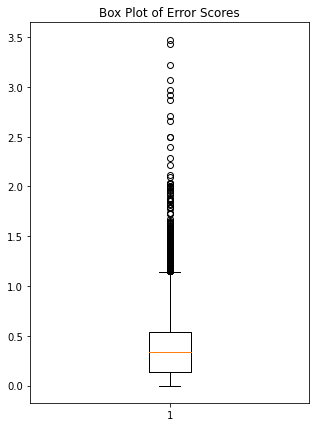

In [ ]:
plt.figure(figsize=(5,7))
plt.boxplot(final_pred['error'])
plt.title('Box Plot of Error Scores')
plt.show()